Last updated: March 31, 2023

**Main Analysis**

## Second-order Effects in Altmetrics: A Case Study Analyzing the Audiences of COVID-19 Research in the News and on Social Media

Juan Pablo Alperin, Alice Fleerackers, Michelle Riedlinger & Stefanie Haustein

**Related Publication:**
Alperin, J.P., Fleerackers, A., Riedlinger, M. & Haustein, S. (2023). Second-order Effects in Altmetrics: A Case Study Analyzing the Audiences of COVID-19 Research in the News and on Social Media. *Zenodo*. 

In [1]:
import os
import datetime
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2 
from matplotlib_venn import venn3 

import sqlite3 as lite
import json
from datetime import datetime
import time
import re

plt.rcParams['figure.figsize'] = (10, 10)

from IPython.core.display import Markdown as md
from IPython.core.display import HTML
pd.options.display.float_format = '{:30,.2f}'.format


def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

def make_doi_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="https://doi.org/{}">{}</a>'.format(val, val)

# Analysis of 2nd order effects for COVID research

In [2]:
#helper function to have Unique Tweets and FB posts depending on level of aggregation

def single_count(df, by_col = None):
    id_col = set(df.columns).intersection(['tweet_id', 'platformId']).pop()
    
    if by_col: 
        return df.groupby([by_col, id_col]).last().reset_index()
    else:
        return df.drop_duplicates(subset=id_col)

In [3]:
outlets_of_interest = ['MSN', 'New York Times', 'BBC News', 'The Guardian', 'Washington Post']
domains_of_interest = ['www.msn.com', 'www.nytimes.com', 'www.bbc.com', 'www.theguardian.com', 'www.washingtonpost.com']

In [4]:
all_articles = pd.read_csv('data/covid_pubmed_ids-20210223.csv', header=None)
all_articles.columns = ['pmid']

In [5]:
# we deduplicate to have unique articles
articles = pd.read_csv('data/dois_in_4_outlets_with_urls.csv')[['doi', 'resolved_url']].drop_duplicates()

def journal_from_url(url):
    if 'bmj' in url:
        return 'British Medical Journal'
    elif 'medrxiv' in url: 
        return 'medRxiv'
    elif 'biorxiv' in url:
        return 'bioRxiv'
    elif 'wiley' in url: 
        return 'Journal of Medical Virology'
    

articles['journal'] = articles.resolved_url.map(journal_from_url)
articles['is_preprint'] = articles.journal.map(lambda x: 'Rxiv' in x)

# News Mentions

In [6]:
news = pd.read_csv('data/altmetric_news_mentions.csv')
news['mention_date'] = pd.to_datetime(news.mention_date).dt.normalize()

news.rename(columns={'url_clean': 'news_url'}, inplace=True)

In [7]:
display(md('{:,} mentions across {:,} unique news stories'.format(news.shape[0], news.news_url.nunique())))


1,406 mentions across 1,221 unique news stories

In [8]:
df = news.groupby('outlet').agg({'news_url': ['nunique', 'size']}).reset_index()
df.columns = ['outlet', 'num stories', 'num mentions']
df.set_index('outlet')

,num stories,num mentions
outlet,,
BBC News,78,83
MSN,743,820
New York Times,232,311
The Guardian,111,123
Washington Post,57,69


In [9]:
num_news_pmids = len(news.pubmed_id.unique())
display(md('{} ({:,.1f}%) of the {:,} articles have at least one mention'.format(num_news_pmids,num_news_pmids/all_articles.shape[0]*100,all_articles.shape[0])))


344 (8.7%) of the 3,934 articles have at least one mention

In [10]:
print("This search revealed that {:,} ({:.1f}%) of the research articles in our sample were mentioned {:,} times across {:,} unique news stories. ".format(
num_news_pmids,num_news_pmids/all_articles.shape[0]*100, news.shape[0], news.news_url.nunique()))

This search revealed that 344 (8.7%) of the research articles in our sample were mentioned 1,406 times across 1,221 unique news stories. 


In [11]:
# Summary of Number of times each DOI gets written about on average
# By how many outlets
d = news.groupby('doi').size().describe()

print("On average, each article was written about {:.1f} times (st. dev. = {:.1f}).".format(d['mean'], d['std']))

On average, each article was written about 4.1 times (st. dev. = 6.5).


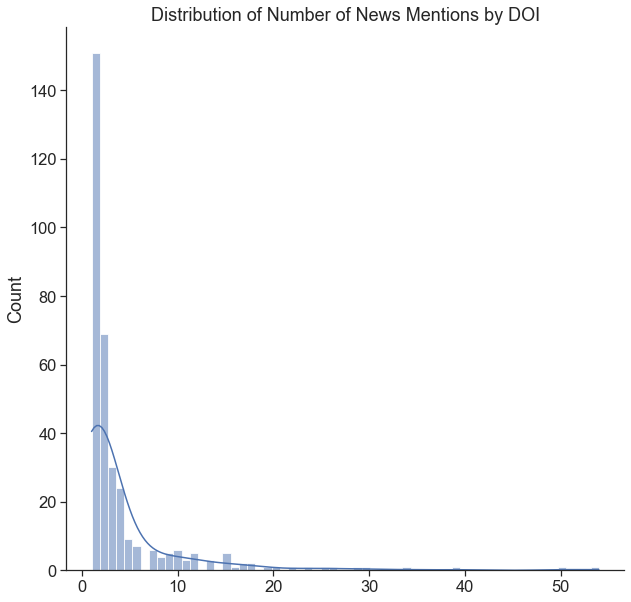

In [12]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

ax = sns.histplot(news.groupby('doi').size(), kde=True)
plt.title('Distribution of Number of News Mentions by DOI')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 


In [13]:
narticles_per_journal = articles.groupby('journal').size()
narticles_per_journal.name = 'N'
df = news.groupby(['journal', 'outlet']).size().unstack()
df = df.join(narticles_per_journal)
df.to_clipboard()
df

,BBC News,MSN,New York Times,The Guardian,Washington Post,N
journal,,,,,,
British Medical Journal,47,262,33,73,22,147
Journal of Medical Virology,11,85,43,4,7,39
bioRxiv,5,116,92,10,10,43
medRxiv,20,357,143,36,30,115


# Twitter Mentions

In [14]:
news_tweets = pd.read_csv('data/citations/twint_news_url_mentions.csv', dtype={'tweet_id': str, 'user_id_str': str}, na_values={'tweet_id': None}, low_memory=False)

# some of the user_id_str's have a .0 at the end beacuse they were treated as a float at some 
# point earlier in the pipeline
news_tweets['user_id_str'] = news_tweets.user_id_str.map(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

# get rid of these 
news_tweets = news_tweets[news_tweets.tweet_id.notnull()]

# rename to avoid ambiguity
news_tweets.rename(columns={'url_clean': 'news_url'}, inplace=True)

news_tweets['created_at'] = pd.to_datetime(news_tweets.created_at)
news_tweets = news_tweets[news_tweets.created_at < '2021-02-01']


# There are a few duplicates caused by multiple moreover URLs resolving to the same thing
news_tweets = news_tweets.drop_duplicates(subset=['doi', 'tweet_id'])

del news_tweets['journal']
news_tweets = news_tweets.merge(articles, how='left', left_on='doi', right_on='doi')

In [15]:

display(md("{:,} Tweets linking to {:,} ({:,.1f}%) of the 1,221 news stories.".format(single_count(news_tweets).shape[0],
                                                                                      len(news_tweets.news_url.unique()),
                                                                                      len(news_tweets.news_url.unique())*100/news.news_url.nunique())))

97,235 Tweets linking to 486 (39.8%) of the 1,221 news stories.

In [16]:
df.columns

Index(['BBC News', 'MSN', 'New York Times', 'The Guardian', 'Washington Post',
       'N'],
      dtype='object')

In [17]:
##
## Twint data for research mentions
##

df = pd.read_csv('data/citations/twint_research_url_mentions.csv', dtype={'tweet_id': str, 'user_id_str': str}, na_values={'tweet_id': None}, low_memory=False)

df['created_at'] = pd.to_datetime(df.created_at)
df = df[df.created_at < '2021-02-01']

# get rid of these for now
df = df[df.tweet_id.notnull()]

# This is different from the "articles" data because it has multiple URLs for every DOI
doi_to_url = pd.read_csv('data/dois_in_4_outlets_with_urls.csv')
df1 = doi_to_url[['doi', 'resolved_url']]
df1.columns = ['doi', 'url']
df2 = doi_to_url[['doi', 'doi_url1']]
df2.columns = ['doi', 'url']
doi_to_url = df1.append(df2).drop_duplicates().set_index('url')

df = df.merge(doi_to_url, how='left', left_on='url_clean', right_index=True)    

# now that we're done, remove to avoid ambiguity
del df['url_clean']
    
research_tweets = df.merge(articles, how='left', left_on='doi', right_on='doi')
del df

In [18]:
display(md("{:,} Tweets linking to {} ({:,.1f}%) of the 344 research articles.".format(single_count(research_tweets).shape[0], 
                                                                                    len(research_tweets.doi.unique()),
                                                                                    len(research_tweets.doi.unique())*100/num_news_pmids)))

50,299 Tweets linking to 325 (94.5%) of the 344 research articles.

# FB Mentions

In [19]:
fb_reaction_cols = ['actualLikeCount', 'actualLoveCount', 'actualWowCount', 'actualHahaCount','actualSadCount', 'actualAngryCount', 'actualThankfulCount']


In [20]:
news_fb = pd.read_csv('data/citations/crowdtangle_news_url_mentions.csv')
news_fb = news_fb[news_fb.platformId.map(lambda x: type(x) == str)] # loose a couple of malformed 
#keep every entry only once per post/link combo | shouldn't be duplicates here anyway
news_fb = news_fb.drop_duplicates(subset=['platformId', 'originalLink'])

news_fb.rename(columns={'date': 'created_at'}, inplace=True)
news_fb['created_at'] = pd.to_datetime(news_fb.created_at).dt.normalize()

# Keep only things that go until December 31, 2020
news_fb = news_fb[news_fb.created_at < '2021-02-01']


news_fb['any_reaction'] = news_fb[fb_reaction_cols].sum(axis=1)

news_fb = news_fb.merge(news[['news_url', 'doi', 'outlet']], how='left', left_on='originalLink', right_on='news_url')
news_fb = news_fb.merge(articles, how='left', left_on='doi', right_on='doi')



In [21]:
print("{:,} FB Posts linking to {:,} ({:,.1f}%) of the 1,221 news stories.".format(single_count(news_fb).shape[0],
                                                                                      len(news_fb.news_url.unique()),
                                                                                      len(news_fb.news_url.unique())*100/news.news_url.nunique()))

14,083 FB Posts linking to 516 (42.3%) of the 1,221 news stories.


In [22]:
# based on resolved URL
research_fb = pd.read_csv('data/citations/crowdtangle_research_url_mentions.csv')

#keep every entry only once per post/link combo 
research_fb = research_fb.drop_duplicates(subset=['platformId', 'originalLink'])

research_fb.rename(columns={'date': 'created_at'}, inplace=True)
research_fb['created_at'] = pd.to_datetime(research_fb.created_at).dt.normalize()

# Keep only things that go until December 31, 2020
research_fb = research_fb[research_fb.created_at < '2021-02-01']


research_fb['page_id'] = research_fb.platformId.map(lambda x: str(x).split('_')[0])
research_fb['facebook_id'] = research_fb.platformId.map(lambda x: str(x).split('_')[1] if '_' in x else None)

research_fb['any_reaction'] = research_fb[fb_reaction_cols].sum(axis=1)

# This is different from the "article" data because it has multiple URLs for every DOI
df = pd.read_csv('data/dois_in_4_outlets_with_urls.csv')
df1 = df[['doi', 'resolved_url']]
df1.columns = ['doi', 'url']
df2 = df[['doi', 'doi_url1']]
df2.columns = ['doi', 'url']
doi_to_url = df1.append(df2).drop_duplicates().set_index('url')

# add the DOI column
research_fb = research_fb.merge(doi_to_url, how='left', left_on='originalLink', right_on='url')

# now that we're done, remove to avoid ambiguity
del research_fb['originalLink']

# remove duplicates if we found the same post using two different URLs
research_fb = research_fb.drop_duplicates(subset=['platformId', 'doi'])

# add the article info columns
research_fb = research_fb.merge(articles, how='left', left_on='doi', right_on='doi')

print("Number of Research FB Posts: {:,}".format(single_count(research_fb).shape[0]))

Number of Research FB Posts: 6,420


In [23]:
print("{:,} FB Posts linking to {} ({:,.1f}%) of the 344 research articles.".format(single_count(research_fb).shape[0], 
                                                                                    len(research_fb.doi.unique()),
                                                                                    len(research_fb.doi.unique())*100/num_news_pmids))

6,420 FB Posts linking to 246 (71.5%) of the 344 research articles.


# Start of analysis

In [24]:
# Count each tweet only once

def summary_cols(platform):
    return ['_'.join([c,platform]) for c in ['num_posts', 'num_spaces', 'num_shares', 'num_likes', 'num_replies']]

def summarize_posts(df, platform, normalize=False):
    names = summary_cols(platform)
    agg_funcs = ['nunique', 'nunique', 'sum', 'sum', 'sum']
    
    if platform == 'tw':
        cols = ['tweet_id', 'user_id_str', 'nretweets', 'nlikes', 'nreplies']
    elif platform == 'fb':
        cols = ['platformId', 'accountId', 'actualShareCount', 'any_reaction', 'actualCommentCount']

    agg_dict = {c: a for c, a in zip(cols, agg_funcs)}

    tmp = df[cols].agg(agg_dict)
    
    if type(tmp) == pd.Series:
        tmp.index = names
        tmp = tmp.astype(int)
        
        if normalize:
            tmp2 = tmp[names[1:]].divide(tmp[names[0]])
            tmp2.index = [x+'_avg' for x in names[1:]]
            tmp = tmp.append(tmp2)
    else:
        tmp.columns = names
        tmp = tmp.astype(int)
        
        if normalize:
            tmp2= tmp[names[1:]].divide(tmp[names[0]], axis=0)
            tmp2.columns = [x+'_avg' for x in names[1:]]
            tmp = tmp.merge(tmp2, how='left', left_index=True, right_index=True)
        
    return tmp

sum1 = summarize_posts(single_count(news_tweets), 'tw', True)
sum1.name = 'news'


sum2 = summarize_posts(single_count(research_tweets), 'tw', True)
sum2.name = 'research'

# display(md('## Tweet Summary'))
summary = pd.DataFrame(sum1).join(sum2)
summary['multiplier'] = summary.news.divide(summary.research)
summary.to_clipboard()
display(md('### Comparing research and news on Twitter'))
summary

### Comparing research and news on Twitter

,news,research,multiplier
num_posts_tw,"97,235.00","50,299.00",1.93
num_spaces_tw,"60,296.00","27,771.00",2.17
num_shares_tw,"412,509.00","227,041.00",1.82
num_likes_tw,"1,111,458.00","512,308.00",2.17
num_replies_tw,"89,509.00","39,788.00",2.25
num_spaces_tw_avg,0.62,0.55,1.12
num_shares_tw_avg,4.24,4.51,0.94
num_likes_tw_avg,11.43,10.19,1.12
num_replies_tw_avg,0.92,0.79,1.16


In [25]:
display(md('## News Tweets'))
display(md('### By Outlet'))

df = summarize_posts(single_count(news_tweets, 'outlet').groupby('outlet'), 'tw', True)
display(df)
m = summarize_posts(news_tweets.groupby('news_url'), 'tw', False).corr(method='spearman').min().min()
print(f'Minimum correlation is {m:.2f}')
print()

display(md('### By Outlet per number of stories'))
normalize = news_tweets.groupby('outlet')['news_url'].nunique()
df = summarize_posts(news_tweets.groupby('outlet'), 'tw').divide(normalize, axis=0)
df['Num Stories'] = normalize
display(df)


## News Tweets

### By Outlet

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,num_spaces_tw_avg,num_shares_tw_avg,num_likes_tw_avg,num_replies_tw_avg
outlet,,,,,,,,,
BBC News,6280,5357,8864,23452,3482,0.85,1.41,3.73,0.55
MSN,99,94,18,34,18,0.95,0.18,0.34,0.18
New York Times,66502,40990,299798,854592,67329,0.62,4.51,12.85,1.01
The Guardian,14033,10574,63118,127689,7641,0.75,4.50,9.10,0.54
Washington Post,10324,7453,40712,105695,11040,0.72,3.94,10.24,1.07


Minimum correlation is 0.88



### By Outlet per number of stories

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,Num Stories
outlet,,,,,,
BBC News,114.18,97.40,165.40,440.42,67.47,55
MSN,2.25,2.14,0.43,0.91,0.48,44
New York Times,295.56,182.18,"1,659.00","4,854.77",386.66,225
The Guardian,133.65,100.70,644.45,"1,285.05",77.37,105
Washington Post,181.12,130.75,754.91,"1,938.28",202.16,57


In [26]:
print()
display(md('### By Journal'))
df = summarize_posts(news_tweets.groupby('journal'), 'tw', True)
display(df)


display(md('### By Journal per number of articles'))
display(md('(first column is Average Posts Per Article)'))
normalize = news_tweets.groupby('journal')['doi'].nunique()
df = summarize_posts(news_tweets.groupby('journal'), 'tw').divide(normalize, axis=0)
df['Num DOIs'] = normalize
display(df)

### By Journal

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,num_spaces_tw_avg,num_shares_tw_avg,num_likes_tw_avg,num_replies_tw_avg
journal,,,,,,,,,
British Medical Journal,18206,13997,88391,216415,17291,0.77,4.86,11.89,0.95
Journal of Medical Virology,7293,5980,18342,40175,5164,0.82,2.52,5.51,0.71
bioRxiv,20314,14305,62770,166440,14205,0.70,3.09,8.19,0.70
medRxiv,61227,40359,323585,938969,73717,0.66,5.29,15.34,1.20


### By Journal per number of articles

(first column is Average Posts Per Article)

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,Num DOIs
journal,,,,,,
British Medical Journal,233.41,179.45,"1,133.22","2,774.55",221.68,78
Journal of Medical Virology,429.00,351.76,"1,078.94","2,363.24",303.76,17
bioRxiv,677.13,476.83,"2,092.33","5,548.00",473.50,30
medRxiv,816.36,538.12,"4,314.47","12,519.59",982.89,75


In [27]:
display(md('### By Outlet Num Posts Details'))
df = news_tweets.groupby(['outlet', 'news_url']).size().reset_index().groupby('outlet')[0].describe()
df = df.join(news_tweets.groupby('outlet')['tweet_id'].nunique())
df.columns = ['Number of Stories', 'Mean Numer of Tweets', 'St. Dev.', 'Minimum', '25%', '50%', '75%', 'Maximum', 'Total Tweets']
df.to_clipboard()
df

### By Outlet Num Posts Details

,Number of Stories,Mean Numer of Tweets,St. Dev.,Minimum,25%,50%,75%,Maximum,Total Tweets
outlet,,,,,,,,,
BBC News,55.00,123.47,254.32,1.00,8.50,28.00,97.50,"1,102.00",6280
MSN,44.00,2.95,5.78,1.00,1.00,1.00,2.00,36.00,99
New York Times,225.00,380.64,994.82,1.00,28.00,73.00,274.00,"8,950.00",66502
The Guardian,105.00,143.38,241.92,2.00,44.00,72.00,172.00,"2,153.00",14033
Washington Post,57.00,203.33,286.27,1.00,31.00,90.00,206.00,"1,278.00",10324


In [28]:
display(md("### Top tweeted news"))
df = single_count(news_tweets, 'news_url')
df = df.groupby(['outlet', 'news_url', 'mention_title']).size().nlargest(20).reset_index()
df.columns = ['outlet', 'news_url', 'mention_title', 'num tweets']
df.style.format({'news_url': make_clickable, 
                'num tweets': lambda x: "{:,}".format(x)})
df.to_clipboard()
df

### Top tweeted news

,outlet,news_url,mention_title,num tweets
0,New York Times,https://www.nytimes.com/interactive/2020/us/co...,How the Virus Won,4475
1,New York Times,https://www.nytimes.com/2020/05/20/us/coronavi...,"Lockdown Delays Cost at Least 36,000 Lives, Da...",4470
2,New York Times,https://www.nytimes.com/2020/04/08/science/new...,Most New York Coronavirus Cases Came From Euro...,3876
3,New York Times,https://www.nytimes.com/2020/11/17/health/coro...,"Immunity to the Coronavirus May Last Years, Ne...",3289
4,New York Times,https://www.nytimes.com/2020/08/11/health/coro...,ëA Smoking Guní: Infectious Coronavirus Retrie...,2633
5,New York Times,https://www.nytimes.com/2020/12/20/health/coro...,The Coronavirus Is Mutating. What Does That Me...,2282
6,The Guardian,https://www.theguardian.com/commentisfree/2020...,The government's secretive Covid contracts are...,2153
7,New York Times,https://www.nytimes.com/2020/05/15/world/coron...,Why Are Women-Led Nations Doing Better With Co...,2015
8,New York Times,https://www.nytimes.com/2020/08/24/health/fda-...,F.D.A. ëGrossly Misrepresentedí Blood Plasma D...,1947
9,New York Times,https://www.nytimes.com/2020/09/09/health/coro...,How the Coronavirus Attacks the Brain,1578


In [29]:
# NB: single_count is not necessary here because already unique by DOI

display(md("### Top tweeted research by news story"))
display(md('(the research whose stories were tweeted the most)'))
top_dois = single_count(news_tweets, 'doi').groupby('doi').size().nlargest(10).index

df = single_count(news_tweets[news_tweets.doi.isin(top_dois)], 'doi').groupby(['doi', 'article_title', 'journal', 'outlet']).size().unstack().fillna(0)
df['Total'] = df.sum(axis=1)

df = df.sort_values('Total', ascending=False).applymap(lambda x: "{:,.0f}".format(x)).reset_index()         
df.to_clipboard()
df.style.format({'doi': make_doi_clickable})





### Top tweeted research by news story

(the research whose stories were tweeted the most)

outlet,doi,article_title,journal,BBC News,MSN,New York Times,The Guardian,Washington Post,Total
0,10.1101/2020.05.15.20103655,Differential Effects of Intervention Timing on COVID-19 Spread in the United States,medRxiv,61,1,"11,295",73,472,"11,902"
1,10.1101/2020.04.16.20065920,Outcomes of hydroxychloroquine usage in United States veterans hospitalized with Covid-19,medRxiv,0,0,"4,103",492,"1,159","5,754"
2,10.1101/2020.08.11.20171843,Functional SARS-CoV-2-specific immune memory persists after mild COVID-19,medRxiv,0,9,"4,732",0,55,"4,796"
3,10.1101/2020.11.15.383323,Immunological memory to SARS-CoV-2 assessed for up to eight months after infection,bioRxiv,0,8,"4,378",91,0,"4,477"
4,10.1101/2020.04.15.20064931,Sequencing identifies multiple early introductions of SARS-CoV-2 to the New York City Region,medRxiv,0,0,"4,475",0,0,"4,475"
5,10.1101/2020.03.25.20043828,Coast-to-coast spread of SARS-CoV-2 in the United States revealed by genomic epidemiology,medRxiv,0,0,"3,876",0,0,"3,876"
6,10.1101/2020.08.03.20167395,Viable SARS-CoV-2 in the air of a hospital room with COVID-19 patients,medRxiv,0,4,"3,321",0,262,"3,587"
7,10.1136/bmj.m2486,Covid-19: Local health teams trace eight times more contacts than national service,British Medical Journal,0,0,0,"2,534",0,"2,534"
8,10.1101/2020.08.12.20169359,Effect of Convalescent Plasma on Mortality among Hospitalized Patients with COVID-19: Initial Three-Month Experience,medRxiv,0,10,"2,376",0,134,"2,520"
9,10.1101/2020.12.05.20241927,Neutralising antibodies in Spike mediated SARS-CoV-2 adaptation,medRxiv,9,0,"2,355",0,134,"2,498"


In [30]:
display(md('## Research Tweets'))
display(md('### By Journal'))
display(summarize_posts(research_tweets.groupby('journal'), 'tw', True))
m = summarize_posts(research_tweets.groupby('doi'), 'tw', False).corr(method='spearman').min().min()
display(summarize_posts(research_tweets.groupby('doi'), 'tw', False).corr(method='spearman'))
print(f'Minimum correlation is {m:.2f}')
print()

display(md('### By Journal per number of articles'))
display(md('(first column is Average Posts Per Article)'))
normalize = research_tweets.groupby('journal')['doi'].nunique()
df = summarize_posts(research_tweets.groupby('journal'), 'tw').divide(normalize, axis=0)
df['Num DOIs'] = normalize
display(df)

## Research Tweets

### By Journal

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,num_spaces_tw_avg,num_shares_tw_avg,num_likes_tw_avg,num_replies_tw_avg
journal,,,,,,,,,
British Medical Journal,42374,23408,191260,413248,31679,0.55,4.51,9.75,0.75
Journal of Medical Virology,751,610,3472,7875,676,0.81,4.62,10.49,0.90
bioRxiv,1725,1257,9493,31327,2726,0.73,5.50,18.16,1.58
medRxiv,5452,3755,25509,68254,5694,0.69,4.68,12.52,1.04


,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw
num_posts_tw,1.00,1.00,0.91,0.92,0.95
num_spaces_tw,1.00,1.00,0.92,0.92,0.95
num_shares_tw,0.91,0.92,1.00,0.98,0.93
num_likes_tw,0.92,0.92,0.98,1.00,0.95
num_replies_tw,0.95,0.95,0.93,0.95,1.00


Minimum correlation is 0.91



### By Journal per number of articles

(first column is Average Posts Per Article)

,num_posts_tw,num_spaces_tw,num_shares_tw,num_likes_tw,num_replies_tw,Num DOIs
journal,,,,,,
British Medical Journal,288.26,159.24,"1,301.09","2,811.21",215.50,147
Journal of Medical Virology,28.88,23.46,133.54,302.88,26.00,26
bioRxiv,41.07,29.93,226.02,745.88,64.90,42
medRxiv,49.56,34.14,231.90,620.49,51.76,110


In [31]:
display(md("### Top tweeted articles"))
df = research_tweets.groupby('doi').size().nlargest(10).reset_index()
df.columns = ['doi', 'num tweets']
df.style.format({'doi': make_doi_clickable, 
                'num tweets': lambda x: "{:,}".format(x)})

### Top tweeted articles

,doi,num tweets
0,10.1136/bmj.m4425,"5,542"
1,10.1136/bmj.m4037,"3,676"
2,10.1136/bmj.m3223,"2,309"
3,10.1136/bmj.m3563,"2,154"
4,10.1136/bmj.m1932,"1,973"
5,10.1136/bmj.m4857,"1,431"
6,10.1136/bmj.m1375,"1,127"
7,10.1136/bmj.m1849,"1,112"
8,10.1136/bmj.m1931,"1,070"
9,10.1136/bmj.m1808,"1,001"


In [32]:
# add in the rank of the DOI in terms of how often it is tweeted on its own
display(md("### Top tweeted research by news compared to top tweeted research"))
display(md('(the research whose stories were tweeted the most compared to the research that was tweeted the most)'))

df = single_count(news_tweets, 'doi').groupby('doi').size().nlargest(10)
df = df.to_frame()
df.columns = ['num_news_tweets']
df['rank_news'] = df['num_news_tweets'].rank(ascending=False, method='min').astype(int)
df = df.join(news_tweets[['doi', 'article_title']].drop_duplicates().set_index('doi'))

df2 = research_tweets.groupby('doi').size().to_frame()
df2.columns = ['num_research_tweets']
df2['rank_research'] = df2['num_research_tweets'].rank(ascending=False, method='min').astype(int)
df = df.join(df2)
df = df[['article_title', 'num_news_tweets', 'rank_news', 'num_research_tweets', 'rank_research']]

df.to_clipboard()

df = df.reset_index()
df.style.format({'doi': make_doi_clickable, 
                'num tweets': lambda x: "{:,}".format(x)})

twitter_top_10 = df.copy()

### Top tweeted research by news compared to top tweeted research

(the research whose stories were tweeted the most compared to the research that was tweeted the most)

In [33]:
fb_cols = ['num_posts_fb', 'num_spaces_fb', 'num_reactions_fb', 'num_shares_fb', 'num_comments_fb']

def summarize_fb(df):
    tmp = df[['platformId', 'any_reaction', 'actualShareCount', 'actualCommentCount', 'accountId']] \
                    .agg({'platformId': 'size', 
                     'accountId': 'nunique',
                     'any_reaction': 'sum', 
                     'actualShareCount': 'sum',
                     'actualCommentCount': 'sum'})
    if type(tmp) == pd.Series:
        tmp.index = fb_cols
    else:
        tmp.columns = fb_cols
    return tmp

sum1 = summarize_posts(single_count(news_fb), 'fb', True)
sum1.name = 'news'


sum2 = summarize_posts(single_count(research_fb), 'fb', True)
sum2.name = 'research'

display(md('## Facebook Summary'))
summary = pd.DataFrame(sum1).join(sum2)
summary['multiplier'] = summary.news.divide(summary.research)
summary.to_clipboard()
display(md('###  Comparing research and news on Facebook'))
summary.applymap(lambda x: "{:,.1f}".format(x))

## Facebook Summary

###  Comparing research and news on Facebook

,news,research,multiplier
num_posts_fb,"14,083.0","6,420.0",2.2
num_spaces_fb,"8,193.0","3,976.0",2.1
num_shares_fb,"412,114.0","89,422.0",4.6
num_likes_fb,"1,476,264.0","176,890.0",8.3
num_replies_fb,"304,633.0","36,203.0",8.4
num_spaces_fb_avg,0.6,0.6,0.9
num_shares_fb_avg,29.3,13.9,2.1
num_likes_fb_avg,104.8,27.6,3.8
num_replies_fb_avg,21.6,5.6,3.8


In [34]:
display(md('## News FB Posts'))
display(md('### By Outlet'))
display(summarize_posts(news_fb.groupby('outlet'), 'fb', True))
m = summarize_posts(news_fb.groupby('news_url'), 'fb', False).corr(method='spearman').min().min()
print(f'Minimum correlation is {m:.2f}')
print()


display(md('### By Outlet per number of stories'))
normalize = news_fb.groupby('outlet')['news_url'].nunique()
df = summarize_posts(news_fb.groupby('outlet'), 'fb').divide(normalize, axis=0)
df['Num Stories'] = normalize
display(df)

## News FB Posts

### By Outlet

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,num_spaces_fb_avg,num_shares_fb_avg,num_likes_fb_avg,num_replies_fb_avg
outlet,,,,,,,,,
BBC News,1885,1510,47317,155545,37398,0.80,25.10,82.52,19.84
MSN,288,180,4567,18549,13567,0.62,15.86,64.41,47.11
New York Times,7490,4800,359906,1532876,253021,0.64,48.05,204.66,33.78
The Guardian,2943,1766,44120,108379,27000,0.60,14.99,36.83,9.17
Washington Post,1477,1077,57412,175654,44073,0.73,38.87,118.93,29.84


Minimum correlation is 0.75



### By Outlet per number of stories

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,Num Stories
outlet,,,,,,
BBC News,27.32,21.88,685.75,"2,254.28",542.00,69
MSN,2.29,1.43,36.25,147.21,107.67,126
New York Times,46.81,30.00,"2,249.41","9,580.48","1,581.38",160
The Guardian,27.76,16.66,416.23,"1,022.44",254.72,106
Washington Post,26.85,19.58,"1,043.85","3,193.71",801.33,55


In [35]:
display(md('### By Outlet Num Posts Details'))
df = news_fb.groupby(['outlet', 'news_url']).size().reset_index().groupby('outlet')[0].describe()
df = df.join(news_fb.groupby('outlet')['platformId'].nunique())
df.columns = ['Number of Stories', 'Mean Numer of FB Posts', 'St. Dev.', 'Minimum', '25%', '50%', '75%', 'Maximum', 'Total FB Posts']
df.to_clipboard()
df

### By Outlet Num Posts Details

,Number of Stories,Mean Numer of FB Posts,St. Dev.,Minimum,25%,50%,75%,Maximum,Total FB Posts
outlet,,,,,,,,,
BBC News,69.00,29.00,52.77,1.00,5.00,8.00,27.00,339.00,1885
MSN,126.00,2.67,3.72,1.00,1.00,1.00,3.00,34.00,288
New York Times,160.00,65.40,147.70,1.00,6.00,18.00,51.25,"1,112.00",7490
The Guardian,106.00,29.62,48.59,1.00,6.00,12.50,31.50,323.00,2943
Washington Post,55.00,35.65,68.63,1.00,4.50,11.00,35.00,406.00,1477


In [36]:
display(md('### By Journal'))
display(summarize_posts(news_fb.groupby('journal'), 'fb', True))
print()

display(md('### By Journal per number of articles'))
normalize = news_fb.groupby('journal')['doi'].nunique()
df = summarize_posts(news_fb.groupby('journal'), 'fb').divide(normalize, axis=0)
df['Num DOIs'] = normalize
display(df)

### By Journal

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,num_spaces_fb_avg,num_shares_fb_avg,num_likes_fb_avg,num_replies_fb_avg
journal,,,,,,,,,
British Medical Journal,3400,2166,104333,335200,63790,0.64,30.69,98.59,18.76
Journal of Medical Virology,998,875,27158,103319,13672,0.88,27.21,103.53,13.70
bioRxiv,2895,2123,66230,402411,60733,0.73,22.88,139.00,20.98
medRxiv,8103,5352,315601,1150073,236864,0.66,38.95,141.93,29.23


### By Journal per number of articles

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,Num DOIs
journal,,,,,,
British Medical Journal,38.64,24.61,"1,185.60","3,809.09",724.89,88
Journal of Medical Virology,47.52,41.67,"1,293.24","4,919.95",651.05,21
bioRxiv,93.39,68.48,"2,136.45","12,981.00","1,959.13",31
medRxiv,106.62,70.42,"4,152.64","15,132.54","3,116.63",76


In [37]:
display(md("### Top FB Posted research by news story"))
display(md('(the research whose stories were posted on FB the most)'))
top_dois = news_fb.groupby('doi').size().nlargest(10).index

df = news_fb[news_fb.doi.isin(top_dois)].groupby(['doi', 'outlet']).size().unstack().fillna(0)
df['Total'] = df.sum(axis=1)
df = df.sort_values('Total', ascending=False).applymap(lambda x: "{:,.0f}".format(x)).reset_index()
df.style.format({'doi': make_doi_clickable})

### Top FB Posted research by news story

(the research whose stories were posted on FB the most)

outlet,doi,BBC News,MSN,New York Times,The Guardian,Washington Post,Total
0,10.1101/2020.05.15.20103655,16,10,"1,131",12,46,"1,215"
1,10.1101/2020.08.11.20171843,0,23,758,0,9,790
2,10.1101/2020.04.16.20065920,0,8,462,72,186,728
3,10.1101/2020.11.15.383323,0,18,597,25,0,640
4,10.1101/2020.08.03.20167395,0,12,471,0,38,521
5,10.1136/bmj.m2486,0,0,0,430,0,430
6,10.1101/2020.04.15.20064931,0,0,409,0,0,409
7,10.1101/2020.09.22.20199125,0,2,0,0,406,408
8,10.1101/2020.03.09.20033217,346,14,0,32,0,392
9,10.1101/2020.04.05.20054502,89,0,0,254,6,349


In [38]:
display(md('## Research FB Posts'))
display(md('### By Journal'))
display(summarize_posts(research_fb.groupby('journal'), 'fb', True))
m = summarize_posts(research_fb.groupby('doi'), 'fb', False).corr(method='spearman').min().min()
print(f'Minimum correlation is {m:.2f}')


display(md('### By Journal per number of articles'))
normalize = research_fb.groupby('journal')['doi'].nunique()
df = summarize_posts(research_fb.groupby('journal'), 'fb').divide(normalize, axis=0)
df['Num DOIs'] = normalize
display(df)

## Research FB Posts

### By Journal

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,num_spaces_fb_avg,num_shares_fb_avg,num_likes_fb_avg,num_replies_fb_avg
journal,,,,,,,,,
British Medical Journal,5363,3335,71482,132100,31247,0.62,13.33,24.63,5.83
Journal of Medical Virology,137,126,1155,2320,464,0.92,8.43,16.93,3.39
bioRxiv,221,190,1765,6834,1196,0.86,7.99,30.92,5.41
medRxiv,700,594,16654,37495,4515,0.85,23.79,53.56,6.45


Minimum correlation is 0.80


### By Journal per number of articles

,num_posts_fb,num_spaces_fb,num_shares_fb,num_likes_fb,num_replies_fb,Num DOIs
journal,,,,,,
British Medical Journal,39.15,24.34,521.77,964.23,228.08,137
Journal of Medical Virology,10.54,9.69,88.85,178.46,35.69,13
bioRxiv,7.89,6.79,63.04,244.07,42.71,28
medRxiv,10.29,8.74,244.91,551.40,66.40,68


In [39]:
display(md("### Top posted articles"))
df = research_fb.groupby('doi').size().nlargest(10).reset_index()
df.columns = ['doi', 'num posts']
df.style.format({'doi': make_doi_clickable})

### Top posted articles

,doi,num posts
0,10.1136/bmj.m4425,906
1,10.1136/bmj.m4037,574
2,10.1136/bmj.m3223,350
3,10.1136/bmj.m1435,306
4,10.1136/bmj.m1375,285
5,10.1136/bmj.m3563,245
6,10.1136/bmj.m1932,242
7,10.1136/bmj.m4857,187
8,10.1136/bmj.m1808,132
9,10.1136/bmj.m1931,120


In [40]:
# add in the rank of the DOI in terms of how often it is tweeted on its own
display(md("### Top FB research by news compared to top tweeted research"))
display(md('(the research whose stories were most posted on FB the most compared to the research that was posted on FB the most)'))

df = single_count(news_fb, 'doi').groupby('doi').size().nlargest(10)
df = df.to_frame()
df.columns = ['num_news_fb']
df['rank_news'] = df['num_news_fb'].rank(ascending=False, method='min').astype(int)
df = df.join(news_tweets[['doi', 'article_title']].drop_duplicates().set_index('doi'))

df2 = research_fb.groupby('doi').size().to_frame()
df2.columns = ['num_research_fb']
df2['rank_research'] = df2['num_research_fb'].rank(ascending=False, method='min')
df = df.join(df2).fillna(0)
df['rank_research'] = df['rank_research'].astype(int)
df = df[['article_title', 'num_news_fb', 'rank_news', 'num_research_fb', 'rank_research']]
df['rank_research'] = df['rank_research'].astype(int)
df['num_research_fb'] = df['num_research_fb'].astype(int)


df.to_clipboard()

df = df.reset_index()

df.style.format({'doi': make_doi_clickable, 
                'num_news_fb': lambda x: "{:,}".format(x),
                 'num_research_fb': lambda x: "{:,}".format(x)})

fb_top_10 = df.copy()

### Top FB research by news compared to top tweeted research

(the research whose stories were most posted on FB the most compared to the research that was posted on FB the most)

In [41]:
nt_cnts = single_count(news_tweets, 'doi').groupby('doi').size().to_frame()
nt_cnts.columns = ['news_tweets']
rt_cnts = research_tweets.groupby('doi').size().to_frame()
rt_cnts.columns = ['research_tweets']

nfb_cnts = single_count(news_fb, 'doi').groupby('doi').size().to_frame()
nfb_cnts.columns = ['news_fb']
rfb_cnts = research_fb.groupby('doi').size().to_frame()
rfb_cnts.columns = ['research_fb']

for df in [nt_cnts, rt_cnts, nfb_cnts, rfb_cnts]:
    for c in df.columns:
        df[c + '_rank'] = df[c].rank(ascending=False, method='min').astype(int)

df = news_tweets[['doi', 'article_title']].drop_duplicates().set_index('doi')
df = df.join(nt_cnts).join(nfb_cnts, how="outer").join(rt_cnts, how="outer").join(rfb_cnts, how="outer")
df = df[(df.news_tweets_rank <= 10) | (df.news_fb_rank <= 10)]
df = df.sort_values('news_tweets_rank').fillna(0)
df.to_clipboard()



In [42]:
by_doi_tw = summarize_posts(news_tweets.groupby('doi'), 'tw').merge(summarize_posts(research_tweets.groupby('doi'), 'tw'), how='outer', left_index=True, right_index=True, suffixes=['_news', '_research']).fillna(0).astype(int)
by_doi_fb = summarize_posts(news_fb.groupby('doi'), 'fb').merge(summarize_posts(research_fb.groupby('doi'), 'fb'), how='outer', left_index=True, right_index=True, suffixes=['_news', '_research']).fillna(0).astype(int)
by_doi = by_doi_tw.merge(by_doi_fb, how='outer', left_index=True, right_index=True)

main_cols = ['num_posts_%s_%s' % (p,c) for p in ['tw', 'fb'] for c in ['research', 'news']]

by_doi_main = by_doi[main_cols]
# display(by_doi)

def make_wordy_col_names(c): 
    if 'research' in c: 
        ret = 'First-order %s (Research)'
    elif 'news' in c:
        ret = 'Second-order %s (News)'
    else:
        return "Bad Column Name"
        
    if 'tw' in c:
        return ret % 'Twitter'
    elif 'fb' in c:
        return ret % 'Facebook'

by_doi_main.columns = [make_wordy_col_names(c) for c in by_doi_main.columns]



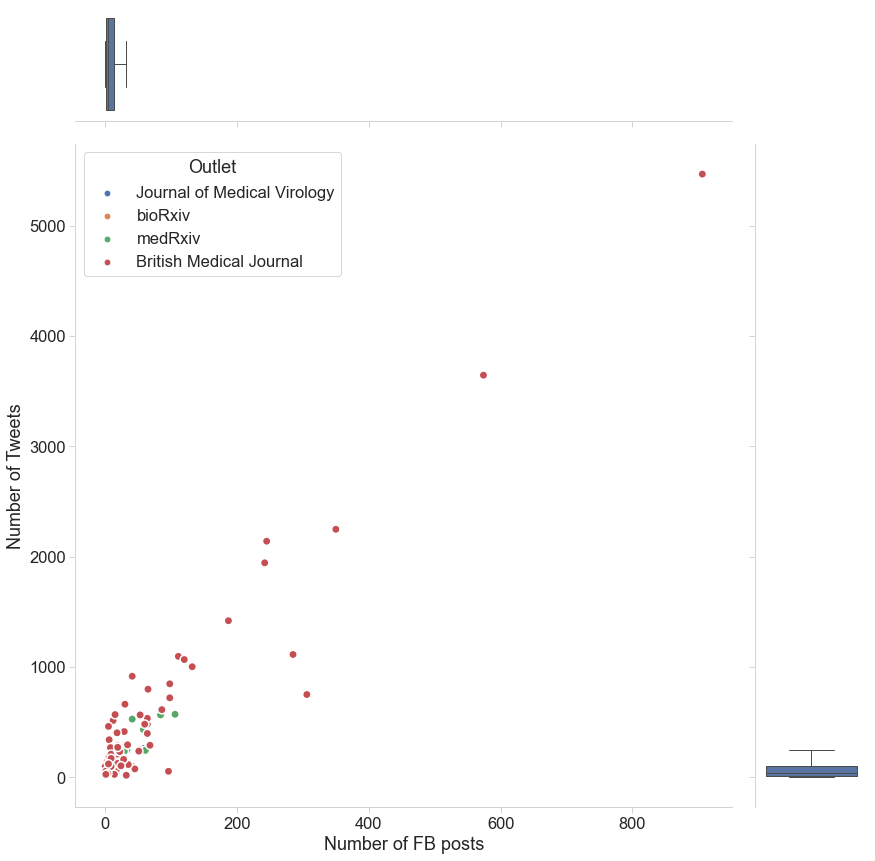

In [43]:
sns.set_style("ticks")

df = by_doi.merge(articles[['doi', 'journal']], left_index=True, right_on='doi').set_index('doi')

x, y, hue = df['num_posts_fb_research'], df['num_posts_tw_research'], df['journal']
g = sns.JointGrid(height=12)

hue_order = ['Journal of Medical Virology',  'bioRxiv', 'medRxiv', 'British Medical Journal' ]
sns.scatterplot(x=x, y=y, hue=hue,  hue_order=hue_order, s=70, linewidth=1.5, ax=g.ax_joint)
g.ax_joint.legend(title='Outlet', markerscale=.8)
g.ax_joint.set_xlabel('Number of FB posts')
g.ax_joint.set_ylabel('Number of Tweets')

sns.boxplot(x=x, showfliers=False, linewidth=1, ax=g.ax_marg_x)
sns.boxplot(y=y, showfliers=False, linewidth=1, ax=g.ax_marg_y)

def format_axis(ax):
    for s in ax.spines.values():
        s.set_color('lightgrey')
        s.set_linewidth(1)
    ax.tick_params(color='lightgrey', width=1)
    
format_axis(g.ax_joint)
format_axis(g.ax_marg_x)
format_axis(g.ax_marg_y)

plt.savefig('figures/Social media posts of research articles by journal.png')



In [44]:
from scipy.stats import spearmanr

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

display(md("## Comparing DOIs across outlets and journals"))
display(md("### Correlations in number of posts of research and news across Twitter and FB"))

display(md('''
tweets of news correlated with FB of news, and tweets of research with FB of research

news and research not correlated on either platform
'''))

corr = by_doi_main.corr(method='spearman')
# corr.to_clipboard()
display(md('**Correlations**'))
display(corr)
corr.to_clipboard()
print()
print()
p_s = by_doi_main.corr(method=spearmanr_pval)
display(md('**p-values**'))
display(p_s.applymap(lambda x: "{:,.4f}".format(x)))


## Comparing DOIs across outlets and journals

### Correlations in number of posts of research and news across Twitter and FB


tweets of news correlated with FB of news, and tweets of research with FB of research

news and research not correlated on either platform


**Correlations**

,First-order Twitter (Research),Second-order Twitter (News),First-order Facebook (Research),Second-order Facebook (News)
First-order Twitter (Research),1.00,0.13,0.84,0.02
Second-order Twitter (News),0.13,1.00,-0.01,0.95
First-order Facebook (Research),0.84,-0.01,1.00,-0.00
Second-order Facebook (News),0.02,0.95,-0.00,1.00


**p-values**

,First-order Twitter (Research),Second-order Twitter (News),First-order Facebook (Research),Second-order Facebook (News)
First-order Twitter (Research),1.0000,0.0157,0.0000,0.7059
Second-order Twitter (News),0.0157,1.0000,0.8720,0.0000
First-order Facebook (Research),0.0000,0.8720,1.0000,0.9440
Second-order Facebook (News),0.7059,0.0000,0.9440,1.0000


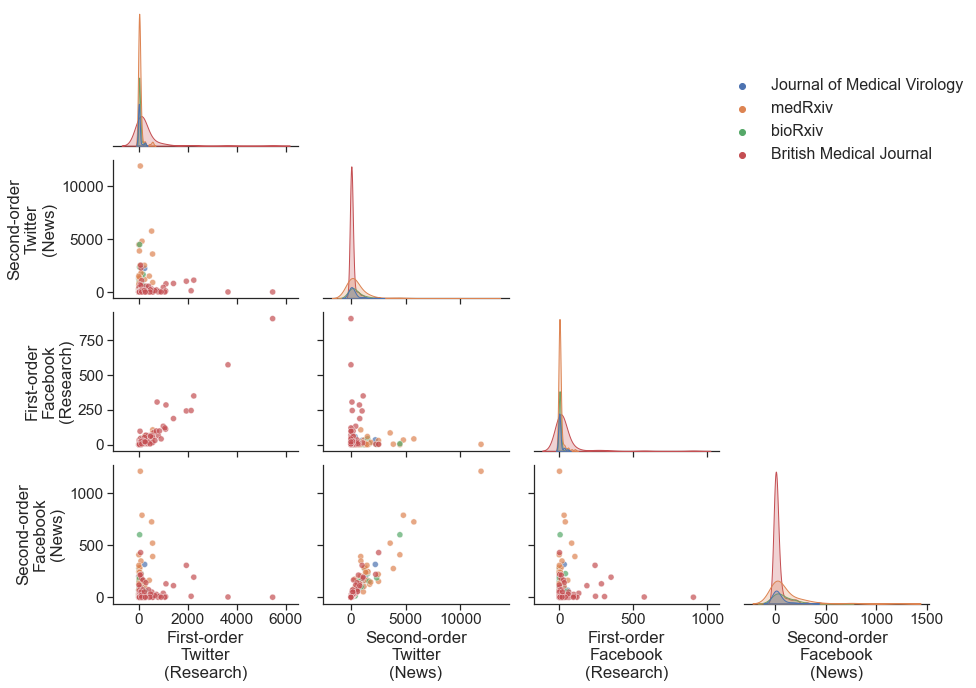

In [45]:
# display(md("### Comparing number of posts of research and news across Twitter and FB"))
# display(md("each dot is a DOI"))

sns.set(font_scale=1.4)
sns.set_style("ticks")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

df = by_doi_main.copy()
def add_newlines_to_cols(c):
    c.split

df.columns = ['\n'.join(c.split()) for c in df.columns]
# df.rename(columns = {'num_posts_tw_news': 'Second Order\nTweets\n(News)', 
#                      'num_posts_tw_research': 'First Order\nTweets\n(Research)', 
#                      'num_posts_fb_news': 'Second Order\nFacebook Posts\n(News)',
#                      'num_posts_fb_research': 'First Order\nFacebook Posts\n(Research)'}, inplace=True)

plt.rcParams['figure.figsize']=18,18
g = sns.pairplot(df.merge(articles[['doi', 'journal']].set_index('doi'), left_index=True, right_index=True), 
                 hue='journal', 
                 plot_kws={'alpha': 0.7},
                 corner=True
                )

g.fig.subplots_adjust(bottom=0.15, left=0.1, right=.95)

handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()

# g.map_upper(hide_current_axis)

# g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=1, frameon=False, fontsize=16, bbox_to_anchor=(1, .9))
# g._legend.set_bbox_to_anchor((1, 1))

# g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), frameon=False, fontsize=14)
# g._legend.set_bbox_to_anchor((0.5, 0))


plt.savefig('figures/pairplot.png')


None

In [46]:
by_journal_tw = summarize_posts(news_tweets.groupby('journal'), 'tw').merge(summarize_posts(research_tweets.groupby('journal'), 'tw'), how='outer', left_index=True, right_index=True, suffixes=['_news', '_research']).fillna(0).astype(int)
by_journal_fb = summarize_posts(news_fb.groupby('journal'), 'fb').merge(summarize_posts(research_fb.groupby('journal'), 'fb'), how='outer', left_index=True, right_index=True, suffixes=['_news', '_research']).fillna(0).astype(int)
by_journal = by_journal_tw.merge(by_journal_fb, how='outer', left_index=True, right_index=True)

by_journal_main = by_journal[main_cols]
# display(by_doi)

In [47]:
display(md("## Summary of number of posts on Twitter and FB: by DOI"))
by_doi_main.describe().applymap(lambda x: "{:,.0f}".format(x))

## Summary of number of posts on Twitter and FB: by DOI

,First-order Twitter (Research),Second-order Twitter (News),First-order Facebook (Research),Second-order Facebook (News)
count,328,328,300,300
mean,154,363,22,57
std,447,984,74,127
min,0,0,0,0
25%,10,0,1,0
50%,36,30,4,9
75%,104,266,13,48
max,"5,467","11,902",906,"1,214"


In [48]:
by_url = summarize_posts(single_count(news_fb, 'news_url').groupby('news_url'), 'fb') \
            .merge(summarize_posts(single_count(news_tweets, 'news_url').groupby('news_url'), 'tw') \
                   , left_on='news_url', right_on='news_url', how='outer').fillna(0)

In [49]:
display(md("## Comparing News Stories across outlets"))
display(md("### Correlations in number of posts of news stories across Twitter and FB"))

display(by_url[['num_%s_%s' % (c, p) for c in ['posts', 'shares', 'likes'] for p in ['tw', 'fb']]].corr(method='spearman'))



## Comparing News Stories across outlets

### Correlations in number of posts of news stories across Twitter and FB

,num_posts_tw,num_posts_fb,num_shares_tw,num_shares_fb,num_likes_tw,num_likes_fb
num_posts_tw,1.00,0.72,0.92,0.65,0.93,0.64
num_posts_fb,0.72,1.00,0.75,0.88,0.74,0.88
num_shares_tw,0.92,0.75,1.00,0.68,0.98,0.68
num_shares_fb,0.65,0.88,0.68,1.00,0.68,0.97
num_likes_tw,0.93,0.74,0.98,0.68,1.00,0.68
num_likes_fb,0.64,0.88,0.68,0.97,0.68,1.00


### Number of Tweets vs FB posts by News Outlet

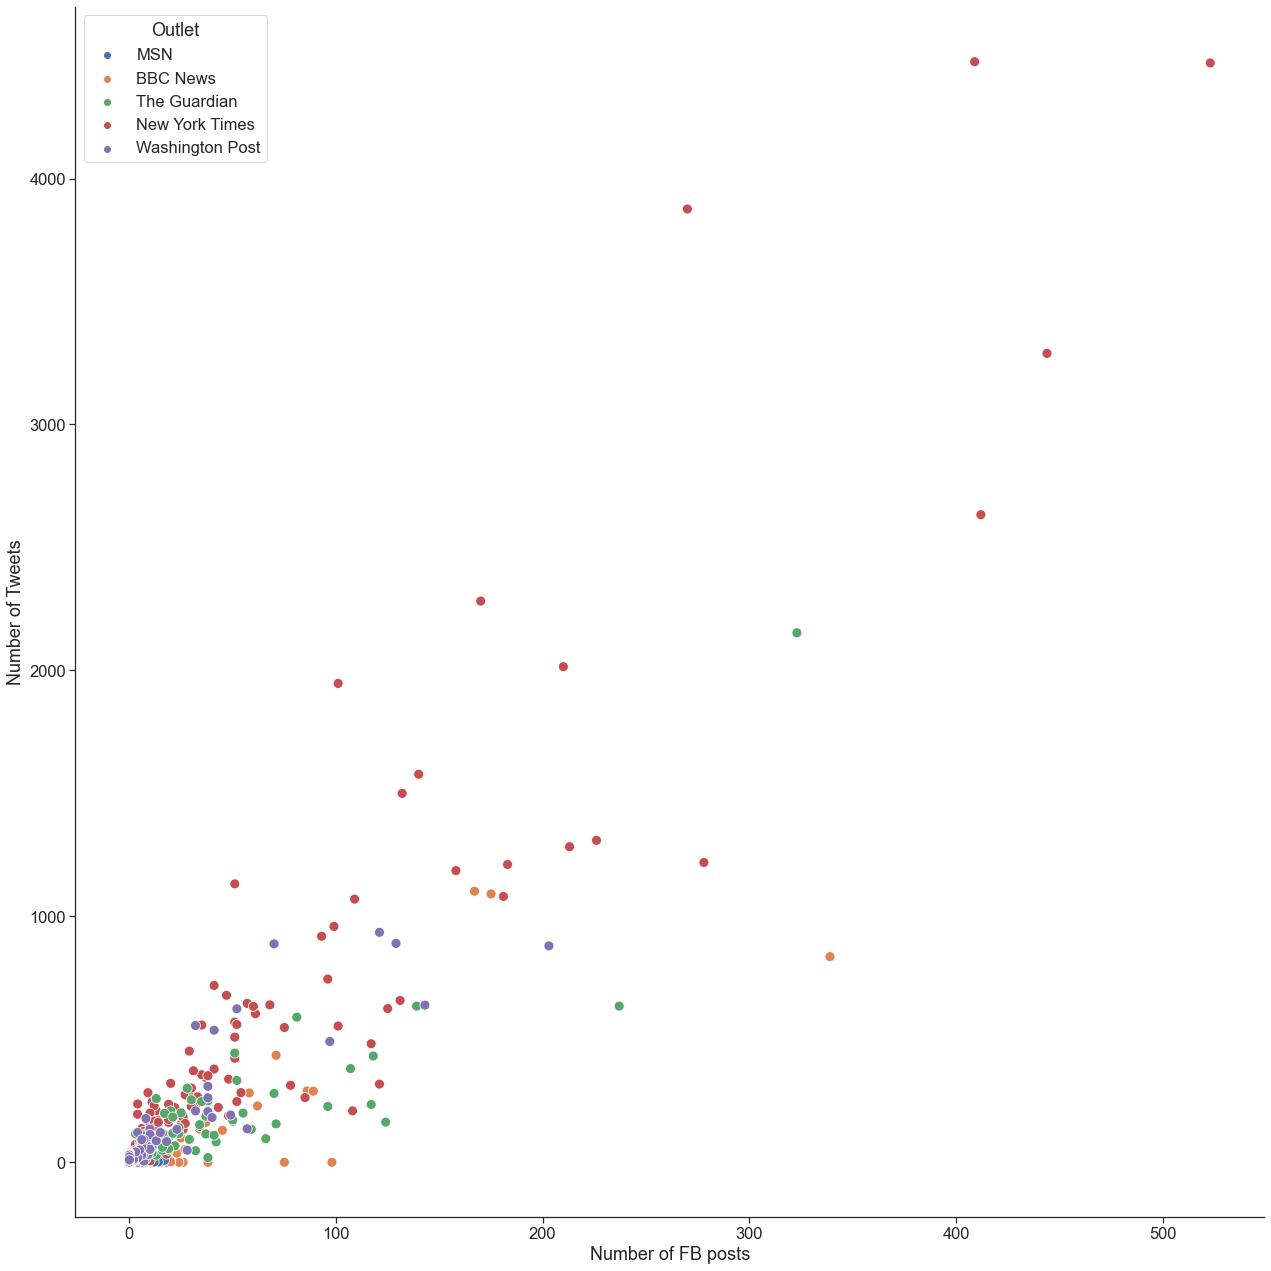

In [50]:
display(md('### Number of Tweets vs FB posts by News Outlet'))

sns.set(font_scale=1.5)
sns.set_style("ticks")

df = by_url.merge(news[['news_url', 'outlet']].drop_duplicates().set_index('news_url'), how='left', left_index=True, right_index=True)
ax = sns.scatterplot(x='num_posts_fb', y='num_posts_tw', hue='outlet', data=df, s=100)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.legend(title='Outlet')
ax.set_xlabel('Number of FB posts')
ax.set_ylabel('Number of Tweets')

plt.tight_layout()

plt.savefig('figures/Social media posts of news stories by outlet.png')



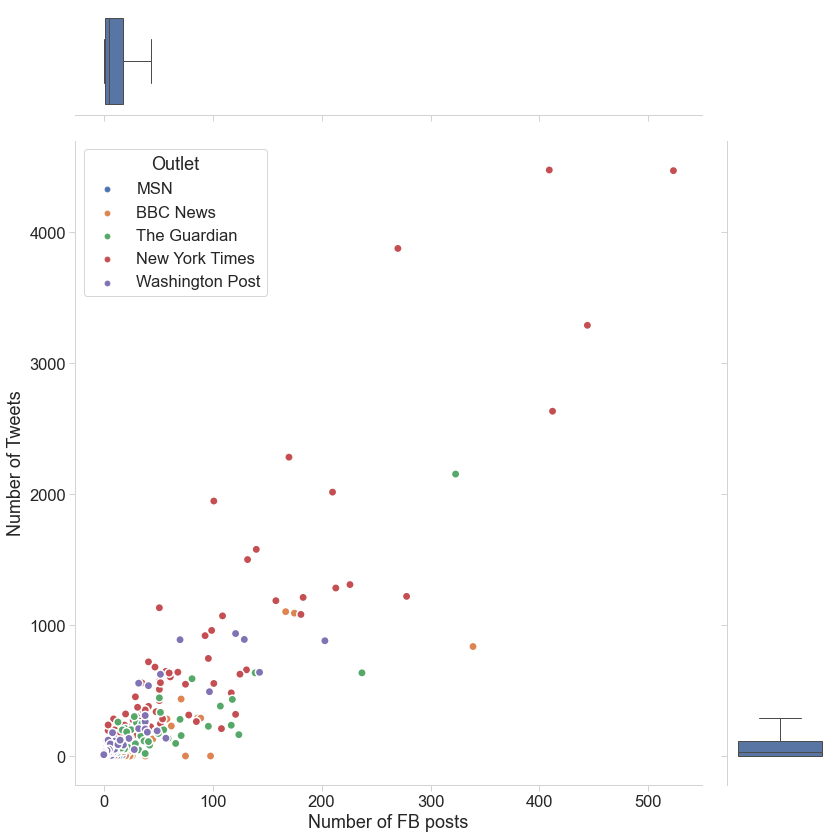

In [51]:
sns.set_style("ticks")

# plt.figure(figsize=(18,16))

df = by_url.merge(news[['news_url', 'outlet']].drop_duplicates().set_index('news_url'), how='left', left_index=True, right_index=True)


x, y, hue = df['num_posts_fb'], df['num_posts_tw'], df['outlet']
g = sns.JointGrid(height=12)

sns.scatterplot(x=x, y=y, hue=hue, s=70, linewidth=1.5, ax=g.ax_joint)
g.ax_joint.legend(title='Outlet', markerscale=.8)
g.ax_joint.set_xlabel('Number of FB posts')
g.ax_joint.set_ylabel('Number of Tweets')

sns.boxplot(x=x, showfliers=False, linewidth=1, ax=g.ax_marg_x)
sns.boxplot(y=y, showfliers=False, linewidth=1, ax=g.ax_marg_y)
# sns.histplot(x=x, fill=False, linewidth=2, ax=g.ax_marg_x)
# sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

def format_axis(ax):
    for s in ax.spines.values():
        s.set_color('lightgrey')
        s.set_linewidth(1)
    ax.tick_params(color='lightgrey', width=1)
    
format_axis(g.ax_joint)
format_axis(g.ax_marg_x)
format_axis(g.ax_marg_y)

# for s in g.ax_joint.spines.values():
#     format_spine(s)

# format_spine(g.ax_marg_x.spines['bottom'])
# format_spine(g.ax_marg_y.spines['left'])
# (x='num_posts_fb', y='num_posts_tw', hue='outlet', data=df, s=100)


# g.plot_joint(sns.scatterplot)
# g.plot_marginals(sns.boxplot)

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False) 

plt.tight_layout()

plt.savefig('figures/Social media posts of news stories by outlet.png')



## Number of unique research articles (DOIs) covered by outlet that month

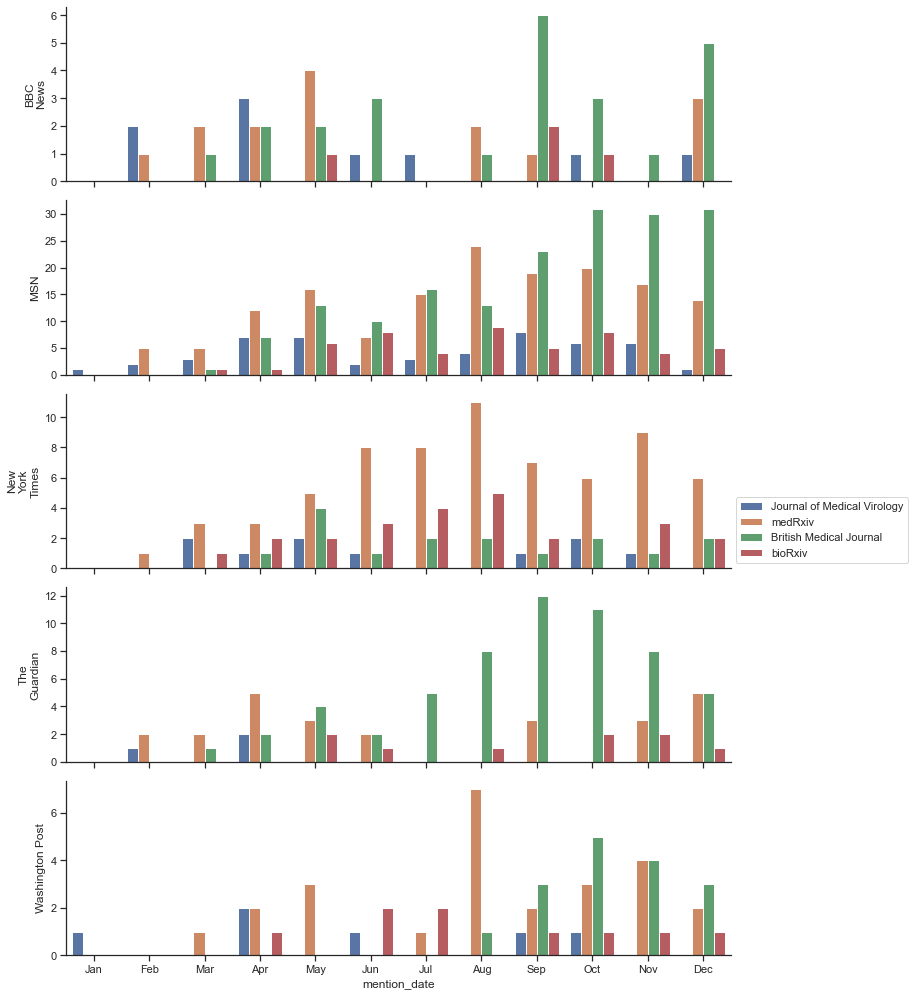

In [52]:
df = news.groupby([pd.Grouper(key='mention_date', freq='M'), 'journal', 'outlet'])['doi'].nunique().unstack().fillna(0)
sns.set(font_scale=1)
sns.set_style("ticks")


fig, axes = plt.subplots(df.shape[1], 1, figsize = (13,14))
for i, c in enumerate(df.columns):
    ax = axes[i]
    df2 = df[c].reset_index()   
    sns.barplot(x='mention_date', y=c, hue='journal', data=df2, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    
    if i != 2: 
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower left', bbox_to_anchor=[1,0])
    if i < (len(df.columns) - 1): 
        ax.set(xticklabels=[])  
        ax.set_xlabel(None)    
        ax.set_ylabel('\n'.join(ax.get_ylabel().split(' ')))
    else: 
        ax.set_xticklabels([datetime.strptime(m.get_text()[0:7], '%Y-%m').strftime('%b') for m in ax.get_xticklabels()]
)
title = 'Number of unique research articles (DOIs) covered by outlet that month'

# ax.set(xticklabels=["%s, %s" % x for x in tmp.index])  
# fig.suptitle(title, fontsize=14)
display(md("## " + title))
plt.tight_layout()

plt.savefig('figures/research_by_outlet_and_journal.jpg')


## Number of stories by outlet

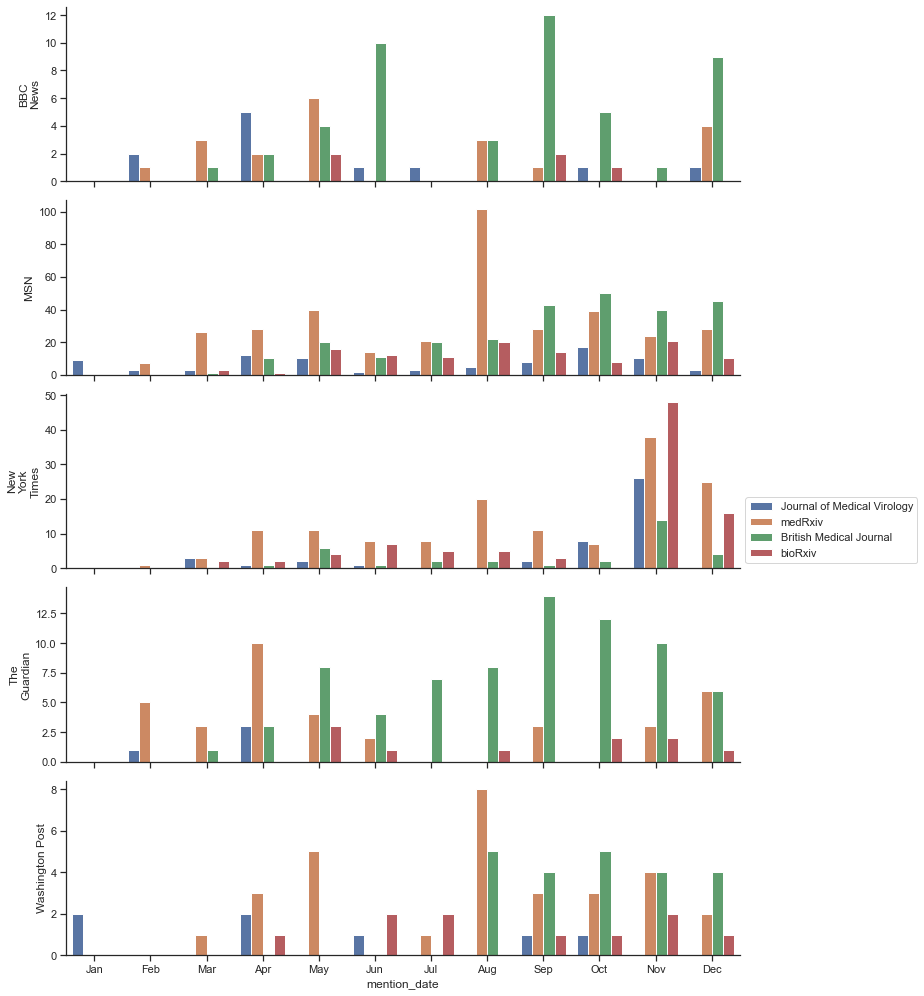

In [53]:
df = news.groupby([pd.Grouper(key='mention_date', freq='M'), 'journal', 'outlet']).size().unstack().fillna(0)

fig, axes = plt.subplots(df.shape[1], 1, figsize = (13,14))
for i, c in enumerate(df.columns):
    ax = axes[i]
    df2 = df[c].reset_index()   
    sns.barplot(x='mention_date', y=c, hue='journal', data=df2, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    
    if i != 2: 
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower left', bbox_to_anchor=[1,0])
    if i < (len(df.columns) - 1): 
        ax.set(xticklabels=[])  
        ax.set_xlabel(None)    
        ax.set_ylabel('\n'.join(ax.get_ylabel().split(' ')))
    else: 
        ax.set_xticklabels([datetime.strptime(m.get_text()[0:7], '%Y-%m').strftime('%b') for m in ax.get_xticklabels()]
)
    
# ax.set(xticklabels=["%s, %s" % x for x in tmp.index]) 
title = 'Number of stories by outlet'
display(md("## " + title))
# fig.suptitle('Number of stories by outlet', fontsize=14)
plt.tight_layout()

plt.savefig('figures/stories_by_outlet_and_journal.jpg')


# Analysis of Number of Users

In [54]:
def summarize_users(setA, setB, labels):
    fieldsA = list(set(['doi', 'news_url']).intersection(setA.columns))
    fieldsB = list(set(['doi', 'news_url']).intersection(setB.columns))    

    user_field = set(setA.columns).intersection(['user_id_str', 'accountId']).pop()
  

    df = setA[fieldsA + [user_field]].nunique().to_frame(labels[0]) \
            .merge(setB[fieldsB + [user_field]].nunique().to_frame(labels[1]) \
                   , how='outer', left_index=True, right_index=True).T

    for c in set(fieldsA).union(fieldsB):
        df['users_per_%s' % c] = df[user_field].divide(df[c])
        
    df[fieldsA] = df[fieldsA].fillna(0).astype(int)
    df[fieldsB] = df[fieldsB].fillna(0).astype(int)
    df[user_field] = df[user_field].astype(int)
    
    setA = set(setA[user_field].astype(str))
    setB = set(setB[user_field].astype(str))
    intersection = len(setA.intersection(setB))
    df['Percent Intersection'] = df[user_field].map(lambda x: intersection*100.0/x)
    
    return df


def draw_user_venn(setA, setB, labels, filename = None):
    user_field = set(setA.columns).intersection(['user_id_str', 'accountId']).pop()
    
    setA = set(setA[user_field].astype(str))
    setB = set(setB[user_field].astype(str))

    plt.figure(figsize=(8,6))
    fig = venn2(subsets = tuple(map(len, (setA.difference(setB), setB.difference(setA), setA.intersection(setB)))), set_labels = labels, subset_label_formatter=lambda x: f'{x:,}')
    plt.tight_layout()
    if filename: 
        plt.savefig(filename)
    return fig


In [55]:
summarize_users(research_tweets, news_tweets, ['r', 'n'])

,doi,news_url,user_id_str,users_per_news_url,users_per_doi,Percent Intersection
r,325,0,27771,nan,85.45,13.99
n,200,486,60296,124.07,301.48,6.44


In [56]:
sentence = '''
As shown in Figure 3, the overlap between the social media audiences of first- and 
second-order citations was very small on both Twitter ({:.1f}% of {:,} who shared research 
and {:.1f}% of {:,} accounts that shared news stories) and Facebook ({:.1f}% of {:,} that shared 
research and {:.1f}% of {:,} spaces that shared news stories).
'''.format(
    len(set(research_tweets.user_id_str).intersection(news_tweets.user_id_str))*100/len(research_tweets.user_id_str.unique()),
    len(research_tweets.user_id_str.unique()),
    len(set(news_tweets.user_id_str).intersection(research_tweets.user_id_str))*100/len(news_tweets.user_id_str.unique()),
    len(news_tweets.user_id_str.unique()),
    len(set(research_fb.accountId).intersection(news_fb.accountId))*100/len(research_fb.accountId.unique()),
    len(research_fb.accountId.unique()),
    len(set(news_fb.accountId).intersection(research_fb.accountId))*100/len(news_fb.accountId.unique()),
    len(news_fb.accountId.unique())
    


)

print(sentence.replace('\n', ''))

As shown in Figure 3, the overlap between the social media audiences of first- and second-order citations was very small on both Twitter (14.0% of 27,771 who shared research and 6.4% of 60,296 accounts that shared news stories) and Facebook (22.6% of 3,976 that shared research and 10.9% of 8,193 spaces that shared news stories).


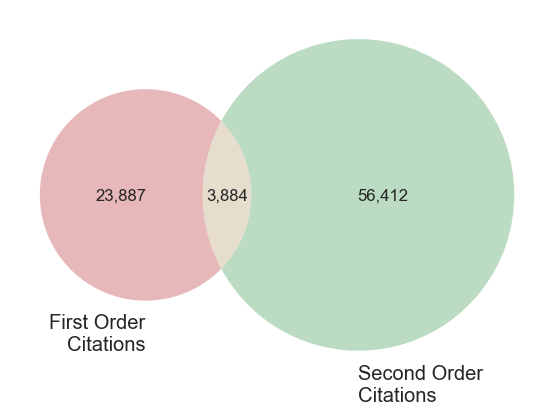

In [57]:
plt.rcParams['figure.figsize'] = (18, 18)
sns.set(font_scale=1.4)
sns.set_style("ticks")

setA = news_tweets
setB = research_tweets

# display(md('### Twitter users for research and News'))
# display(summarize_users(setA, setB, ('News', 'Research')))

fig = draw_user_venn(setB, setA, ('First Order\nCitations', 'Second Order\nCitations'), 'figures/venn_twitter.png')

Mongeon, P., Bowman, T., & Costas, R. (2022). Open dataset of scholars on Twitter [Data set]. *Zenodo*. [https://doi.org/10.5281/zenodo.7013518](https://doi.org/10.5281/zenodo.7013518)

In [58]:
researchers_tw = pd.read_csv('data/authors_tweeters_2022_08_21.csv')
researchers_tw['tweeter_id'] = researchers_tw['tweeter_id'].astype(str)

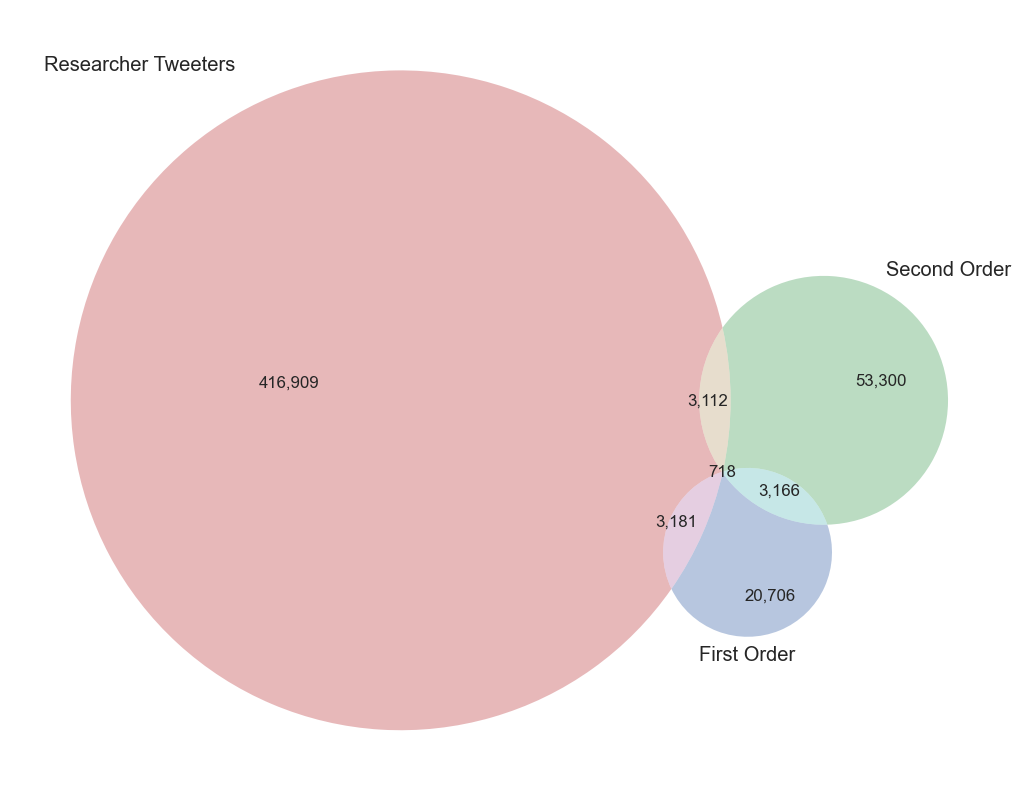

In [59]:
s1 = set(researchers_tw.tweeter_id)
s2 = set(news_tweets.user_id_str)
s3 = set(research_tweets.user_id_str)

# (Set1,Set2,1n2,Set3,1n3,2n3,1n2n3)
venn3(subsets=tuple(map(len, (s1-s2-s3, 
                              s2-s1-s3, 
                              s1.intersection(s2)-s3,
                              s3-s1-s2,
                              s1.intersection(s3)-s2,
                              s2.intersection(s3)-s1,
                              s1.intersection(s2).intersection(s3)))),
     set_labels=('Researcher Tweeters', 'Second Order', 'First Order'),
     subset_label_formatter=lambda x: f'{x:,}')

plt.savefig('figures/venn_researcher_tweeters.png')

In [60]:
sentence = '''Of the {:,} Twitter accounts identified as belonging to a researcher by 
Mongeon, Bowman & Costas (2022), we found small overlaps with the accounts that 
made first- and second-order citations. 
Of the {:,} accounts that made first-order citations, {:,} ({:.1f}%) were known researchers, 
while this number was only {:,} ({:.1f}%) of the {:,} accounts that made second-order citations. 
Only {:,} accounts were in all three groups. 
'''.format(
    len(s1), 
    len(s3), len(s1.intersection(s3)), 100*(len(s1.intersection(s3)))/len(s3), 
    len(s1.intersection(s2)), 100*(len(s1.intersection(s2)))/len(s2), len(s2), 
    len(s1.intersection(s2).intersection(s3))
)

print(sentence.replace('\n', ''))


Of the 423,920 Twitter accounts identified as belonging to a researcher by Mongeon, Bowman & Costas (2022), we found small overlaps with the accounts that made first- and second-order citations. Of the 27,771 accounts that made first-order citations, 3,899 (14.0%) were known researchers, while this number was only 3,830 (6.4%) of the 60,296 accounts that made second-order citations. Only 718 accounts were in all three groups. 


### FB users for research and News

,accountId,doi,news_url,users_per_news_url,users_per_doi,Percent Intersection
News,8193,216,516,15.88,37.93,10.95
Research,3976,246,0,nan,16.16,22.56


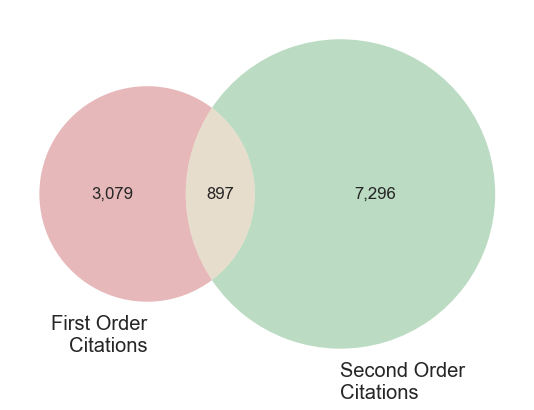

In [61]:
display(md('### FB users for research and News'))
plt.rcParams['figure.figsize'] = (18, 18)
sns.set(font_scale=1.4)
sns.set_style("ticks")

setA = news_fb
setB = research_fb

display(summarize_users(setA, setB, ('News', 'Research')))

draw_user_venn(setB, setA, ('First Order\nCitations', 'Second Order\nCitations'), 'figures/venn_facebook.png')

In [62]:
df = research_tweets.groupby('user_id_str').size().describe().to_frame()
df.columns = ['first_order_tw']

df['second_order_tw'] = news_tweets.groupby('user_id_str').size().describe()
df['first_order_fb'] = research_fb.groupby('accountId').size().describe()
df['second_order_fb'] = news_fb.groupby('accountId').size().describe()
df


,first_order_tw,second_order_tw,first_order_fb,second_order_fb
count,"27,771.00","60,296.00","3,976.00","8,193.00"
mean,1.85,1.98,1.64,2.19
std,4.82,3.70,2.66,3.75
min,1.00,1.00,1.00,1.00
25%,1.00,1.00,1.00,1.00
50%,1.00,1.00,1.00,1.00
75%,2.00,2.00,2.00,2.00
max,379.00,254.00,120.00,133.00


In [63]:
def which_order(user_id_str):
    f = user_id_str in set(research_tweets.user_id_str)
    s = user_id_str in set(news_tweets.user_id_str)
    if f and s: 
        return 'both'
    elif f:
        return 'first'
    elif s:
        return 'second'

df2 = research_tweets.append(news_tweets)
df2['is_researcher'] = df2.user_id_str.isin(researchers_tw.tweeter_id.astype(str))

df = df2.groupby('user_id_str')[['tweet_id', 'nlikes', 'nretweets', 'is_researcher']].agg({'tweet_id': 'nunique', 'nlikes': 'sum', 'nretweets': 'sum', 'is_researcher': 'sum'}).astype(int)
df.columns = ['ntweets', 'nlikes', 'nretweets', 'is_researcher']
df['tweets_rank'] = df.ntweets.rank(ascending=False, method='min').astype(int)
df['likes_rank'] = df.nlikes.rank(ascending=False, method='min').astype(int)
df['retweets_rank'] = df.nretweets.rank(ascending=False, method='min').astype(int)
df = df[(df.tweets_rank <= 10) | (df.likes_rank <= 10) | (df.retweets_rank <= 10)].join(df2[['user_id_str', 'username']].drop_duplicates().set_index('user_id_str'))
df['is_researcher'] = df['is_researcher'].astype(bool)
df['link'] = df.username.map(lambda x: 'https://twitter.com/%s' % x)
df['order'] = df.index.map(which_order)
df.set_index('username', inplace=True)
df.sort_values('tweets_rank', inplace=True)

df = df[['link', 'is_researcher', 'tweets_rank', 'ntweets', 'likes_rank', 'nlikes', 'retweets_rank', 'nretweets', 'order']]
display(df)
df.to_clipboard()



,link,is_researcher,tweets_rank,ntweets,likes_rank,nlikes,retweets_rank,nretweets,order
username,,,,,,,,,
bmj_latest,https://twitter.com/bmj_latest,False,1,379,5,41068,1,27263,first
AndersJonita,https://twitter.com/AndersJonita,False,2,239,1627,87,2364,21,first
uhiiman,https://twitter.com/uhiiman,False,3,236,37069,0,21636,0,second
Thomas_Wilckens,https://twitter.com/Thomas_Wilckens,True,4,226,512,406,403,211,both
BangoBilly,https://twitter.com/BangoBilly,False,5,197,339,664,286,312,both
outbreaksci,https://twitter.com/outbreaksci,False,6,194,7101,11,3950,10,first
BendallJane,https://twitter.com/BendallJane,False,7,179,1378,111,1171,58,both
Artaudculation,https://twitter.com/Artaudculation,False,8,173,1369,112,1317,49,both
pash22,https://twitter.com/pash22,True,9,134,476,441,298,299,both


In [64]:
df2 = research_tweets.append(news_tweets)
df2 = df2[df2.user_id_str.isin(researchers_tw.tweeter_id.astype(str))]

df = df2.groupby('user_id_str')[['tweet_id', 'nlikes', 'nretweets']].agg({'tweet_id': 'nunique', 'nlikes': 'sum', 'nretweets': 'sum'}).astype(int)
df.columns = ['ntweets', 'nlikes', 'nretweets']
df['tweets_rank'] = df.ntweets.rank(ascending=False, method='min').astype(int)
df['likes_rank'] = df.nlikes.rank(ascending=False, method='min').astype(int)
df['retweets_rank'] = df.nretweets.rank(ascending=False, method='min').astype(int)
df = df[(df.tweets_rank <= 10) | (df.likes_rank <= 10) | (df.retweets_rank <= 10)].join(df2[['user_id_str', 'username']].drop_duplicates().set_index('user_id_str')).set_index('username')
df.sort_values('tweets_rank')




,ntweets,nlikes,nretweets,tweets_rank,likes_rank,retweets_rank
username,,,,,,
Thomas_Wilckens,226,406,211,1,152,122
pash22,134,441,299,2,142,98
aruberutou,94,5,0,3,2379,3446
mancunianmedic,86,1082,401,4,57,73
EricTopol,64,22953,10914,5,3,3
apoorva_nyc,63,51607,20876,6,1,1
drjohnmorley,63,46,37,6,683,421
JuanGrvas,57,275,187,8,199,132
InstituteHPE,55,23,40,9,1059,403


In [65]:
df2 = news_tweets.copy()
df = df2.groupby('user_id_str')[['tweet_id', 'nlikes', 'nretweets']].agg({'tweet_id': 'nunique', 'nlikes': 'sum', 'nretweets': 'sum'}).astype(int)
df.columns = ['ntweets', 'nlikes', 'nretweets']
df['tweets_rank'] = df.ntweets.rank(ascending=False, method='min').astype(int)
df['likes_rank'] = df.nlikes.rank(ascending=False, method='min').astype(int)
df['retweets_rank'] = df.nretweets.rank(ascending=False, method='min').astype(int)
df = df[(df.tweets_rank <= 10) | (df.likes_rank <= 10) | (df.retweets_rank <= 10)].join(df2[['user_id_str', 'username']].drop_duplicates().set_index('user_id_str')).set_index('username')
df.sort_values('tweets_rank')




,ntweets,nlikes,nretweets,tweets_rank,likes_rank,retweets_rank
username,,,,,,
uhiiman,236,0,0,1,25190,14749
_be_el_tee_,115,28,10,2,2522,2633
FloLake,94,40,27,3,1958,1332
TimeToSayGood15,94,139,74,3,800,650
samturpin,94,3,0,3,10754,14749
MedPierre,93,24,21,6,2780,1579
sapiopath,88,2,1,7,12516,9804
denio_vale,82,117,84,8,893,588
pash22,71,194,149,9,622,367


In [66]:
df2 = news_tweets.copy()
df = df2.groupby('user_id_str')[['tweet_id', 'nlikes', 'nretweets']].agg({'tweet_id': 'nunique', 'nlikes': 'sum', 'nretweets': 'sum'}).astype(int)
df.columns = ['ntweets', 'nlikes', 'nretweets']
df['tweets_rank'] = df.ntweets.rank(ascending=False, method='min').astype(int)
df['likes_rank'] = df.nlikes.rank(ascending=False, method='min').astype(int)
df['retweets_rank'] = df.nretweets.rank(ascending=False, method='min').astype(int)
df = df[(df.tweets_rank <= 10) | (df.likes_rank <= 10) | (df.retweets_rank <= 10)].join(df2[['user_id_str', 'username']].drop_duplicates().set_index('user_id_str')).set_index('username')
df.sort_values('tweets_rank')




,ntweets,nlikes,nretweets,tweets_rank,likes_rank,retweets_rank
username,,,,,,
uhiiman,236,0,0,1,25190,14749
_be_el_tee_,115,28,10,2,2522,2633
FloLake,94,40,27,3,1958,1332
TimeToSayGood15,94,139,74,3,800,650
samturpin,94,3,0,3,10754,14749
MedPierre,93,24,21,6,2780,1579
sapiopath,88,2,1,7,12516,9804
denio_vale,82,117,84,8,893,588
pash22,71,194,149,9,622,367


### Twitter users for preprint and journal research

,doi,user_id_str,users_per_doi,Percent Intersection
Preprint Research,152,4802,31.59,19.99
Journal Research,173,23929,138.32,4.01


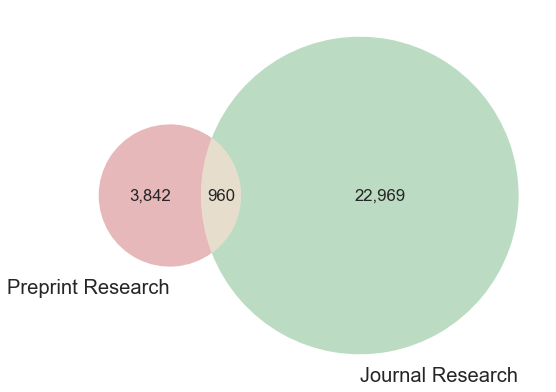

In [67]:
display(md('### Twitter users for preprint and journal research'))
setA = research_tweets[research_tweets.is_preprint]
setB = research_tweets[~research_tweets.is_preprint]

display(summarize_users(setA, setB, ('Preprint Research', 'Journal Research')))

ax = draw_user_venn(setA, setB, ('Preprint Research', 'Journal Research'))

### FB Spaces for preprint and journal research

,doi,accountId,users_per_doi,Percent Intersection
Preprint Research,96,750,7.81,26.53
Journal Research,150,3425,22.83,5.81


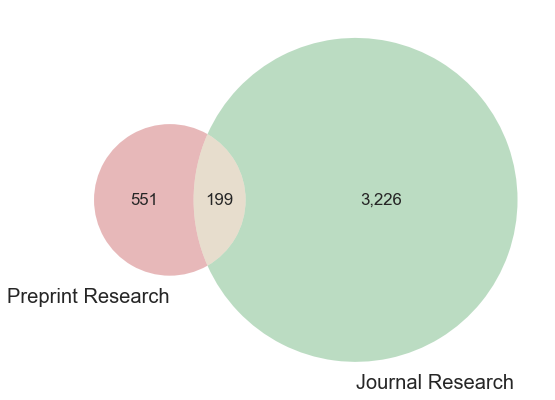

In [68]:
display(md('### FB Spaces for preprint and journal research'))
setA = research_fb[research_fb.is_preprint]
setB = research_fb[~research_fb.is_preprint]

display(summarize_users(setA, setB, ('Preprint Research', 'Journal Research')))

ax = draw_user_venn(setA, setB, ('Preprint Research', 'Journal Research'))

### Twitter users for News that covered preprint and journal research

,news_url,doi,user_id_str,users_per_news_url,users_per_doi,Percent Intersection
News about Preprint Research,311,105,46479,149.45,442.66,9.99
News about Journal Research,199,95,18462,92.77,194.34,25.16


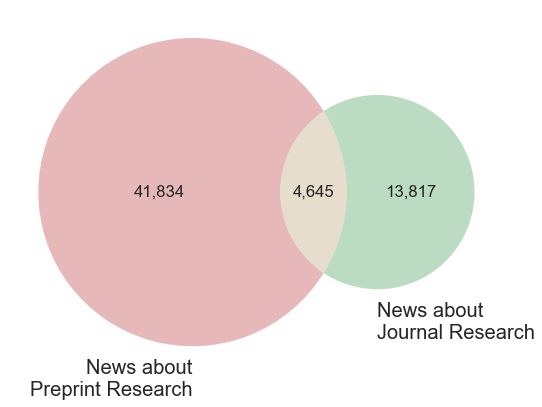

In [69]:
display(md('### Twitter users for News that covered preprint and journal research'))

setA = news_tweets[news_tweets.is_preprint]
setB = news_tweets[~news_tweets.is_preprint]

display(summarize_users(setA, setB, ('News about Preprint Research', 'News about Journal Research')))

ax = draw_user_venn(setA, setB, ('News about\nPreprint Research', 'News about\nJournal Research'))

None

### FB Spaces with News that covered preprint and journal research

,news_url,doi,accountId,users_per_news_url,users_per_doi,Percent Intersection
News about Preprint Research,311,107,6235,20.05,58.27,12.98
News about Journal Research,220,109,2767,12.58,25.39,29.24


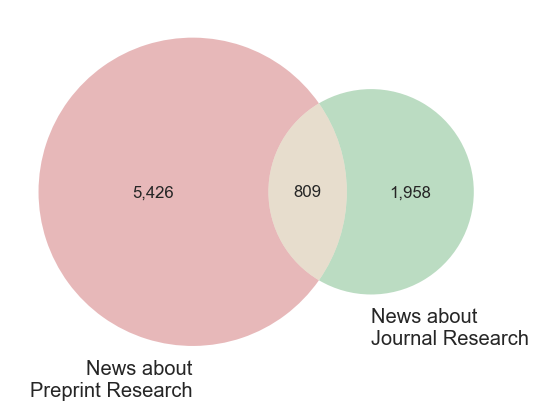

In [70]:
display(md('### FB Spaces with News that covered preprint and journal research'))

setA = news_fb[news_fb.is_preprint]
setB = news_fb[~news_fb.is_preprint]

display(summarize_users(setA, setB, ('News about Preprint Research', 'News about Journal Research')))

ax = draw_user_venn(setA, setB, ('News about\nPreprint Research', 'News about\nJournal Research'))

None